In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# !pip install --quiet missingno
# !pip install --quiet lightgbm
# !pip install bayesian-optimization
# !pip install scikit-optimize

In [1]:
import os
# os.chdir(r"/content/drive/MyDrive/billing_features/raw/")
import math
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import missingno as msno
import pickle
import lightgbm
import xgboost as xgb
#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import auc as auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir=os.getcwd()
os.listdir()

['02_data_preprocessing.py',
 'test',
 'PolicyPremium_Combined.csv',
 'Data Dictionary v4.xlsx',
 'Trident_Data_Explore_0718.ipynb',
 'Anniv_RG_Data_POLICY_2017_2022YTD.txt',
 'Trident_Data_Explore_0708.ipynb',
 '01_feature_engineer.ipynb',
 'Untitled-1.ipynb',
 'utils.py',
 '02_data_preprocessing.ipynb',
 '02_processing.out',
 '01_feature_engineer.py',
 'old_file',
 'churn_labels_update.csv',
 'churn_labels.csv',
 'Trident_Data_Explore_0715.ipynb']

In [4]:
start=time.time()
policy_premium_df = pd.read_csv(os.path.join(data_dir,'PolicyPremium_Combined.csv'))
end=time.time()
print("running time {:.4f}".format(end-start))
policy_premium_df.shape

running time 12.6276


(3626285, 25)

In [5]:
data_dir="/app/models/trident/retention/engineered_update"
# churn_labels = pd.read_csv('churn_labels_update.csv')
churn_labels = pd.read_csv(os.path.join(data_dir,'churn_labels.csv'))
churn_labels.dropna(subset=['churn'],inplace=True)
churn_labels.shape

(444055, 9)

In [6]:
policy_id=np.unique(churn_labels['policy_id'].values)
policy_id.shape

(119672,)

In [7]:
policy_premium_df=policy_premium_df[policy_premium_df["policy_id"].isin(policy_id)]
policy_premium_df.shape

(3625938, 25)

In [8]:
policy_premium_df['year']  = policy_premium_df.bill_due_dt.apply(lambda x: x[:4])
policy_premium_df['month'] = policy_premium_df.bill_due_dt.apply(lambda x: x[5:7])
policy_premium_df['policy_id']=policy_premium_df['policy_id'].astype(int)
policy_premium_df['year']=policy_premium_df['year'].apply(str)
policy_premium_df['month']=policy_premium_df['month'].apply(str)
policy_premium_df.drop(['Unnamed: 0','report_start_dt','report_end_dt','bill_due_dt','bill_gen_dt'], axis=1, inplace=True)
policy_premium_df=policy_premium_df.reset_index(drop=True)

In [9]:
pd.set_option('display.max_columns', None)
policy_premium_df.loc[policy_premium_df.policy_id==607176].head()

,policy_id,CountBills,CountBillGens,CountFirstGenBillsPaidFull,CountBillsPaidFull,CountBillsPaid,OrigBillAmt,CurrBillAmt,CurrPaidAmt,PaidBillDueDays,AvgPdBilldueDays,PaidBillLastGenDays,AvgPdBillLstGenDays,AvgBillGenCnt,AvgPaidFullCnt,AvgFirstGenPaidFullCnt,Lag12_cntBillGens,Lag12_cntPaidFull,Lag12_cntFirstGenPaidFull,Lag12_cntBills,year,month
0,607176,1,1,1,1,1,211.31,211.31,211.31,-4,-4.0,14,14.0,1.0,1.0,1.0,13.0,12.0,11.0,12.0,2020,11
29022,607176,1,1,1,1,1,190.98,190.98,190.98,-10,-10.0,8,8.0,1.0,1.0,1.0,11.0,11.0,11.0,11.0,2018,12
40646,607176,1,1,1,1,1,190.98,190.98,190.98,-10,-10.0,8,8.0,1.0,1.0,1.0,8.0,8.0,8.0,8.0,2018,09
168812,607176,1,1,1,1,1,154.70,154.70,154.70,66,66.0,9,9.0,1.0,1.0,1.0,13.0,12.0,11.0,12.0,2020,03
174802,607176,1,1,1,1,1,190.98,190.98,190.98,-5,-5.0,13,13.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,2018,01


In [10]:
policy_premium_df = policy_premium_df.replace('?', np.nan)
policy_premium_df["AvgPdBilldueDays"]=policy_premium_df["AvgPdBilldueDays"].astype(float)
policy_premium_df["AvgPdBillLstGenDays"]=policy_premium_df["AvgPdBillLstGenDays"].astype(float)
policy_premium_df["Lag12_cntBillGens"]=policy_premium_df["Lag12_cntBillGens"].astype(float)
policy_premium_df["Lag12_cntPaidFull"]=policy_premium_df["Lag12_cntPaidFull"].astype(float)
policy_premium_df["Lag12_cntFirstGenPaidFull"]=policy_premium_df["Lag12_cntFirstGenPaidFull"].astype(float)
policy_premium_df["Lag12_cntBills"]=policy_premium_df["Lag12_cntBills"].astype(float)

policy_premium_df['CountBills'] = policy_premium_df['CountBills'].replace(0, np.nan)
policy_premium_df['AvgPdBilldueDays'] = policy_premium_df['AvgPdBilldueDays'].replace(0, np.nan)
policy_premium_df['AvgPdBillLstGenDays'] = policy_premium_df['AvgPdBillLstGenDays'].replace(0, np.nan)
policy_premium_df['AvgBillGenCnt'] = policy_premium_df['AvgBillGenCnt'].replace(0, np.nan)
policy_premium_df['AvgPaidFullCnt'] = policy_premium_df['AvgPaidFullCnt'].replace(0, np.nan)

In [11]:
# policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)

pd.set_option('display.max_columns', None,'display.max_rows', None)
tempt=pd.DataFrame(policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)).reset_index()
tempt=tempt[tempt[0]>0]
tempt.rename({"index":"variable",0:"missing %"},axis=1).style.format({"missing %":"{:.2%}"})

,variable,missing %
0,AvgPdBillLstGenDays,8.69%
1,AvgPdBilldueDays,5.06%
2,Lag12_cntBills,3.07%
3,Lag12_cntFirstGenPaidFull,3.07%
4,Lag12_cntPaidFull,3.07%
5,Lag12_cntBillGens,3.07%
6,AvgPaidFullCnt,2.76%


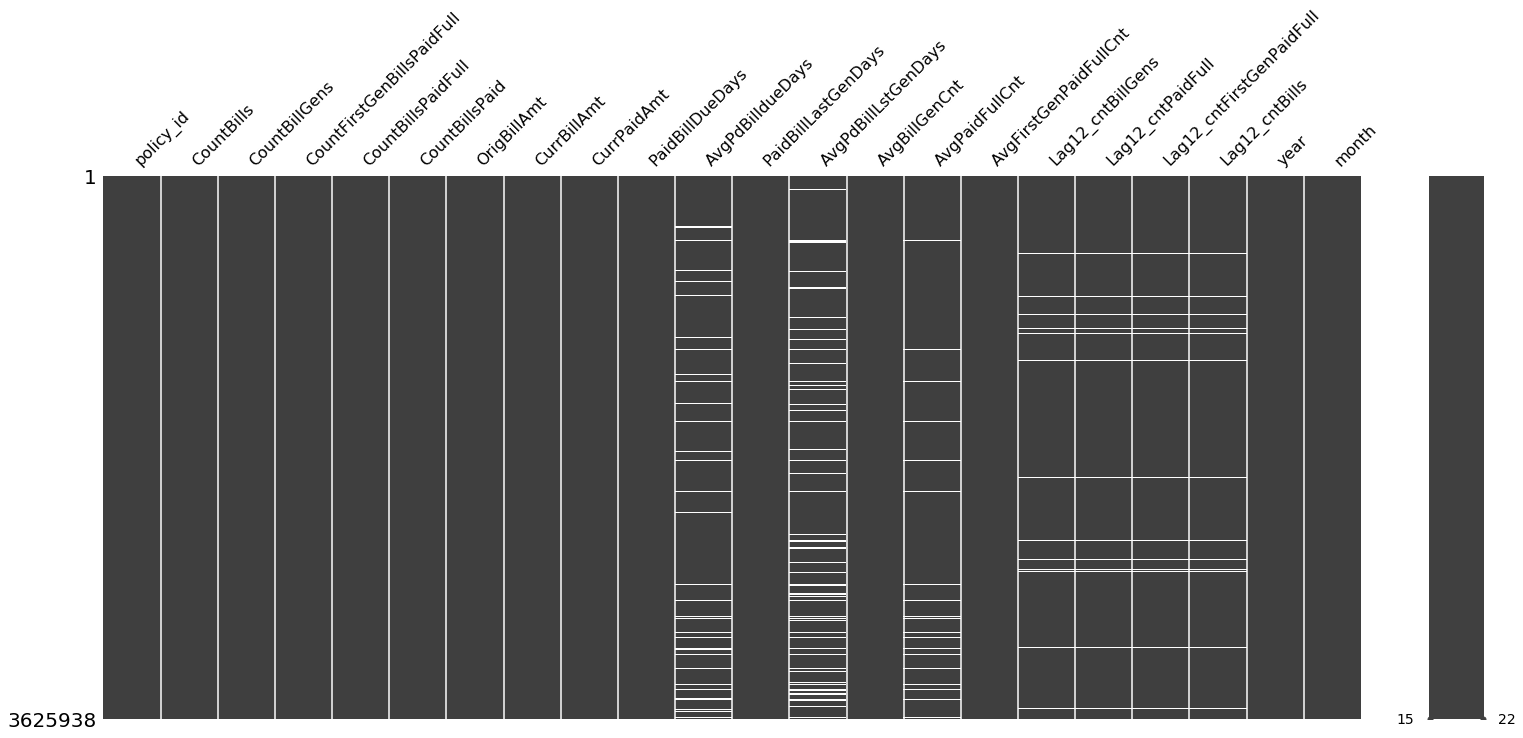

In [12]:
msno.matrix(policy_premium_df)

In [13]:
my_imputer = SimpleImputer()
numeric_columns=[]
categorical_columns=[]
for c in policy_premium_df.columns:
    if policy_premium_df[c].dtypes!="object":
        numeric_columns.append(c)
    else:
        categorical_columns.append(c)

data_numeric=policy_premium_df.loc[:,numeric_columns]
data_numeric=pd.DataFrame(my_imputer.fit_transform(data_numeric),columns=numeric_columns)

data_categorical=policy_premium_df.loc[:,categorical_columns]
policy_premium_df = pd.concat([data_numeric, data_categorical], axis = 1)

In [14]:
policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)

policy_id                     0.0
CountBills                    0.0
year                          0.0
Lag12_cntBills                0.0
Lag12_cntFirstGenPaidFull     0.0
Lag12_cntPaidFull             0.0
Lag12_cntBillGens             0.0
AvgFirstGenPaidFullCnt        0.0
AvgPaidFullCnt                0.0
AvgBillGenCnt                 0.0
AvgPdBillLstGenDays           0.0
PaidBillLastGenDays           0.0
AvgPdBilldueDays              0.0
PaidBillDueDays               0.0
CurrPaidAmt                   0.0
CurrBillAmt                   0.0
OrigBillAmt                   0.0
CountBillsPaid                0.0
CountBillsPaidFull            0.0
CountFirstGenBillsPaidFull    0.0
CountBillGens                 0.0
month                         0.0
dtype: float64

In [15]:
policy_premium_df['policy_id']=policy_premium_df['policy_id'].astype(int)
policy_premium_df['year']=policy_premium_df['year'].apply(int)
policy_premium_df['month']=policy_premium_df['month'].apply(int)

- $\frac{1}{T}\sum_{i=0}^{T}X_{t-i} \;\;\; T=1,2,3,6,12$
<br/><br/>
- $delta=X_t-X_{t-i} \;\;\; i=1,2,3,6,12$
<br/><br/>
- $ratio=\frac{X_t-X_{t-i}}{X_t} \;\;\; i=1,2,3,6,12$

In [16]:
def policy_df_accumulate(df):
    df.sort_values(['policy_id','year','month'],inplace=True)
    df["paid_bill_prop"]=df['CurrPaidAmt'].astype(float)/df['CurrBillAmt'].astype(float)
    # df["idx"]=df.groupby(['policy_id',"year"]).ngroup()
    exc_col=["policy_id","Lag12_cntBillGens","Lag12_cntPaidFull","Lag12_cntFirstGenPaidFull","Lag12_cntBills","year","month"]
    for col in tqdm(df.columns):
        if col not in exc_col:
            if col not in ["OrigBillAmt","CurrBillAmt","CurrPaidAmt","PaidBillDueDays","AvgPdBilldueDays","PaidBillLastGenDays","AvgPdBillLstGenDays","paid_bill_prop"]:
                df["L12_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(12, min_periods=1).sum()))
                df["L6_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(6, min_periods=1).sum()))
                df["L1_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(1, min_periods=1).sum()))
                df["L2_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(2, min_periods=1).sum()))
                df["L3_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(3, min_periods=1).sum()))
            else:
                df["L12_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(12, min_periods=1).mean()))
                df["L6_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(6, min_periods=1).mean()))
                df["L1_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(1, min_periods=1).mean()))
                df["L2_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(2, min_periods=1).mean()))
                df["L3_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(3, min_periods=1).mean()))  
                
#                 df["std12_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(12, min_periods=1).std()))
#                 df["std6_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(6, min_periods=1).std()))
#                 df["std1_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(1, min_periods=1).std()))
#                 df["std2_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(2, min_periods=1).std()))
#                 df["std3_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(3, min_periods=1).std()))
                
        if col not in ["policy_id","year","month"]:
            df["lag1_"+col]=df[col].shift(1)
            df["d1_"+col]=df[col]-df["lag1_"+col]
            df["r1_"+col]=(df[col]-df["lag1_"+col])/df["lag1_"+col]
            df.drop(["lag1_"+col],axis=1,inplace=True)
            
            df["lag2_"+col]=df[col].shift(2)
            df["d2_"+col]=df[col]-df["lag2_"+col]
            df["r2_"+col]=(df[col]-df["lag2_"+col])/df["lag2_"+col]
            df.drop(["lag2_"+col],axis=1,inplace=True)

            df["lag3_"+col]=df[col].shift(3)
            df["d3_"+col]=df[col]-df["lag3_"+col]
            df["r3_"+col]=(df[col]-df["lag3_"+col])/df["lag3_"+col]
            df.drop(["lag3_"+col],axis=1,inplace=True)
            
            df["lag6_"+col]=df[col].shift(6)
            df["d6_"+col]=df[col]-df["lag6_"+col]
            df["r6_"+col]=(df[col]-df["lag6_"+col])/df["lag6_"+col]
            df.drop(["lag6_"+col],axis=1,inplace=True)
            
            df["lag12_"+col]=df[col].shift(12)
            df["d12_"+col]=df[col]-df["lag12_"+col]
            df["r12_"+col]=(df[col]-df["lag12_"+col])/df["lag12_"+col]
            df.drop(["lag12_"+col],axis=1,inplace=True)
            
    # df.drop(['idx'],axis=1,inplace=True) 
               
    return df

In [17]:
df=policy_df_accumulate(policy_premium_df)

 65%|██████▌   | 15/23 [49:48<30:51, 231.43s/it]

In [ ]:
file_output="policy_premium_pickle"
data_dir="/app/models/dij22"
df.to_pickle(os.path.join(data_dir,file_output))

# file_output="policy_premium.csv"
# data_dir="/home/dij22/Trident"
# df.to_csv(os.path.join(data_dir,file_output))

In [3]:
file="policy_premium_pickle"
data_dir="/app/models/dij22"
policy_premium_df=pd.read_pickle(os.path.join(data_dir,file))

# start=time.time()
# file_output="policy_premium.csv"
# policy_premium_df=pd.read_csv(os.path.join(data_dir,file))
# end=time.time()
# print("running time {:.4f}".format(end-start))

In [ ]:
pd.set_option('display.max_columns', None)
policy_premium_df.head()

In [ ]:
policy_premium_df.shape

In [4]:
data_dir="/app/models/trident/retention/engineered_update"
# churn_labels = pd.read_csv('churn_labels_update.csv')
churn_labels = pd.read_csv(os.path.join(data_dir,'churn_labels.csv'))
churn_labels.dropna(subset=['churn'],inplace=True)
# churn_labels['policy_id']=churn_labels['policy_id'].astype(int)
# churn_labels['year']=churn_labels['year'].apply(int)
churn_labels.shape

(445577, 12)

In [ ]:
def pivot_date(df,buffer):
    policy_id=[]
    year=[]
    month=[]
    pivot_date=[]
    policy_year=[]
    churn=[]
    for index,row in tqdm(df.iterrows(), total=df.shape[0]):
        if np.isnan(row["policy_term_month"]):
            date1=str(row["year"])+str(int(row["policy_eff_month"]))
        else:
            date1=str(row["year"])+str(int(row["policy_term_month"]))
        
        date2=pd.to_datetime(str(date1),format="%Y%m")-pd.offsets.DateOffset(months=buffer)
        policy_id.append(row["policy_id"])
        year.append(date2.year)
        month.append(date2.month)
        
        if int(date1[4:])<10:
            date1=date1[:4]+str(0)+date1[4:]
        pivot_date.append(date1)
        policy_year.append(row["policy_year"])
        churn.append(row["churn"])
    churn_data=pd.DataFrame({"policy_id":policy_id,"pivot_date":pivot_date,"year":year,"month":month,"policy_year":policy_year,"churn":churn})
    # churn_data["month"]=output["month"].apply(lambda x: str(x) if x>=10 else str(0)+str(x))
    churn_data['policy_id']=churn_data['policy_id'].astype(int)
    churn_data['year']=churn_data['year'].apply(int)
    churn_data['month']=churn_data['month'].apply(int)
    return churn_data

In [ ]:
churn_data=pivot_date(churn_labels,buffer=3)

In [ ]:
# var=policy_premium_df.columns[:50].tolist()
# tempt=policy_premium_df.loc[:,var]
# df=pd.merge(churn_data,tempt,how="inner", on=["policy_id", "year","month"])
start=time.time()
df=pd.merge(churn_data,policy_premium_df,how="inner", on=["policy_id", "year","month"])
end=time.time()
print("running time {:.4f}".format(end-start))

In [ ]:
# file_output="df_pickle"
# data_dir="/app/models/dij22"
# df.to_pickle(os.path.join(data_dir,file_output))

In [5]:
file="df_pickle"
data_dir="/app/models/dij22"
df=pd.read_pickle(os.path.join(data_dir,file))

In [ ]:
df.shape

In [ ]:
var=["policy_id","pivot_date","year","month","policy_year","churn","CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
df[df.policy_id==151353].loc[:,var]

In [ ]:
var=["policy_id","year","month","CountBillsPaidFull","CountBillsPaid" ,"CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
policy_premium_df[policy_premium_df.policy_id==151353].loc[:,var]

In [ ]:
var=["policy_id","year","policy_eff_month","policy_term_month","policy_year","churn"]
churn_labels[churn_labels.policy_id==151353].loc[:,var]

In [ ]:
pd.set_option('display.max_columns', None,'display.max_rows', None)
tempt=pd.DataFrame(policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)).reset_index()
tempt=tempt[tempt[0]>0]
tempt.rename({"index":"variable",0:"missing %"},axis=1).style.format({"missing %":"{:.4%}"})

In [6]:
df2=df.copy()
df2.dropna(axis = 0, how ='any',inplace=True)
df2.shape

(227406, 306)

In [7]:
print("{:.2%} data was drop".format(1-df2.shape[0]/df.shape[0]))

19.87% data was drop


In [8]:
df2["churn"].value_counts(dropna=False, normalize=True).to_frame().style.format({"churn":"{:.2%}"})

,churn
0,92.63%
1,7.37%


No handles with labels found to put in legend.


<Figure size 720x576 with 0 Axes>

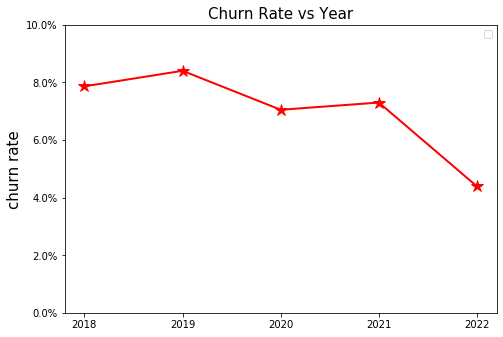

In [9]:
churn_year=df2.groupby(['year']).mean().reset_index().loc[:,["year","churn"]]
churn_year.style.format({"churn":"{.2%}"})

plt.figure(figsize=(10,8))
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes
ax.plot(churn_year["year"],churn_year["churn"],color="r",marker="*",linewidth=2, markersize=12)
ax.set_title("Churn Rate vs Year",fontsize=15)
ax.legend()
ax.set_ylabel("churn rate",fontsize=15)
ax.set_xticks([2018,2019,2020,2021,2022])
ax.set_ylim([0,0.1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.show()

In [ ]:
bin_values = np.arange(start=0, stop=60, step=2)
index = df['year'].isin([2020,2021,2022]) 
py = df[index] # select rows
group = py.groupby('year')['policy_year'] 
group.plot(kind='hist', bins=bin_values, figsize=[12,6], alpha=.4, legend=True) # alpha for transparency
plt.title("Distribution of Policy_Year")

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title("BoxPlot of Policy_Year")

In [ ]:
var='CurrPaidAmt'
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
# ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var}")

In [ ]:
var='CurrBillAmt'
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
# ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var}")

In [ ]:
# df["paid_bill_prop"]=df['CurrPaidAmt'].astype(float)/df['CurrBillAmt'].astype(float)
var='paid_bill_prop'
df[["year",var]].groupby("year").describe()

In [ ]:
var='Lag12_cntBills'
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
# ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var}")
# ax.set_ylim(0,100)

In [ ]:
df[["year","Lag12_cntBills"]].groupby("year").describe()

In [ ]:
var='PaidBillLastGenDays'
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var}")

In [ ]:
var='r12_Lag12_cntBills'
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df, x='year',y=f'{var}', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var}")

In [ ]:
var='r12_Lag12_cntBills'
df[["year",var]].groupby("year").describe()

In [ ]:
# # Changing option to use infinite as nan
# pd.set_option('mode.use_inf_as_na', True)
  
# # Dropping all the rows with nan values
# df.dropna(inplace=True)

In [ ]:
# my_imputer = SimpleImputer()
# numeric_columns=[]
# categorical_columns=[]
# for c in df.columns:
#     if df[c].dtypes!="object":
#         numeric_columns.append(c)
#     else:
#         categorical_columns.append(c)

# data_numeric=df.loc[:,numeric_columns]
# data_numeric=pd.DataFrame(my_imputer.fit_transform(data_numeric),columns=numeric_columns)

# data_categorical=df.loc[:,categorical_columns]
# df2 = pd.concat([data_numeric, data_categorical], axis = 1)

In [10]:
def model_evaluate(target, predicted):
    
    precision, recall, thresholds = precision_recall_curve(target, predicted)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    fscore=fscore[~np.isnan(fscore)]
    ix = np.argmax(fscore)
    f1_score=fscore[ix]
    

    auc=roc_auc_score(target, predicted)
    pr_auc=auc_score(recall,precision)

    thrs=thresholds[ix]
    prec=precision[ix]
    reca=recall[ix]

    true_label_mask=[1 if x>=thrs else 0 for i,x in enumerate(predicted)]

    nb_prediction=len(true_label_mask)
    true_prediction=sum(true_label_mask)
    false_prediction=nb_prediction-true_prediction
    accuracy=true_prediction/nb_prediction
    
    return {
        "nb_example":len(target),
        "true_prediction":true_prediction,
        "false_prediction":false_prediction,
        "accuracy":accuracy,
        "precision":prec, 
        "recall":reca, 
        "f1_score":f1_score,
        "AUC":auc,
        "pr_auc":pr_auc
    }
    
### Binary Analysis
        
def pcut_func(df,var,nbin=5):
    df[var]=df[var].astype(float)
    df["cut"]=pd.qcut(df[var],nbin,precision=2,duplicates="drop")
    decile=df.groupby(df["cut"])['churn'].mean().reset_index()
    decile["cut"]=decile["cut"].astype(str)
    return decile

def myplot(df,var,*args):

    fig, a = plt.subplots(len(args)//2,2,figsize=(12,2.5*len(args)))
    a=a.ravel()
    for idx,ax in enumerate(a):
      df=args[idx]
      ax.plot(df["cut"],df["churn"],color="r",marker="*",linewidth=2, markersize=12)
      ax.set_title(var[idx])
      ax.tick_params(labelrotation=45)
    fig.tight_layout()

def hist_plot(df,var,r):

    fig, a = plt.subplots(len(var)//2,2,figsize=(12,2*len(var)))
    a=a.ravel()
    for idx,ax in enumerate(a):
      
      ax.hist(df.loc[:,var[idx]], bins=20,range=r)
      ax.set_title(var[idx])
      ax.set_xlabel(var[idx])
      ax.set_ylabel("Frequency")
    fig.tight_layout()
    
    
# variable_list=df_feature_importance_v3['feature'].values.tolist()[0:30]

# df3=df2.copy()

# nbin=5
# args=[]
# for idx,v in enumerate(variable_list):
#     x=pcut_func(df3,var=variable_list[idx],nbin=nbin)
#     args.append(x)

# myplot(df3,variable_list,*args)

#### ### original feature + rolling window feature + delta feature + ratio feature

In [11]:
df3=df2.copy()
# exclude_cols=['policy_id', 'pivot_date', 'churn']
# df3["year"]=df3["year"].astype('category')
# df3["month"]=df3["month"].astype('category')

exclude_cols=['policy_id', 'pivot_date', 'churn',"year","month"]

# target=df3.loc[:,["year","churn"]]
# feature=df3.drop(exclude_cols, axis=1)
# X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=0.25,stratify=target,random_state=101)

train_data=df3[df3["year"]!=2022]
test_data=df3[df3["year"]==2022]

y_train=train_data.loc[:,"churn"]
y_test=test_data.loc[:,"churn"]
X_train=train_data.drop(exclude_cols, axis=1)
X_test=test_data.drop(exclude_cols, axis=1)


print("{:<30}{:<20,}".format('training features: ', len(X_train)))
print("{:<30}{:<20,}".format('testing features: ', len(X_test)))
# print("{:<30}{:<20,}".format('training features: ', len(y_train)))
# print("{:<30}{:<20,}".format('testing features: ', len(y_test)))
# print(y_train.value_counts(dropna=False,normalize=True).to_frame())
pd.DataFrame(y_test, columns=["churn"])["churn"].value_counts(dropna=False,normalize=True).to_frame().style.format({"churn":"{:.2%}"})

training features:            206,569             
testing features:             20,837              


,churn
0,95.61%
1,4.39%


#### Tuning Hypterparameters LGBM

In [22]:
%%time

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lightgbm.Dataset(data=X, label=y, free_raw_data=False)

    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        params["verbose"]=-1
        
        cv_result = lightgbm.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =-1, metrics=['auc'])  


        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.5, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (10, 100),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 20.7 µs


In [23]:
opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9738161284258351, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9738161284258351
|  1        |  0.7438   |  0.9738   |  0.2812   |  0.5985   |  49.98    |  24.1     |  10.26    |  35.74    |  74.94    |  0.4615   |
|  2        |  0.7355   |  0.9909   |  0.7939   |  0.9862   |  84.63    |  12.59    |  86.15    |  12.12    |  67.99    |  0.258    |
|  3        |  0.741    |  0.548    |  0.8548   |  0.8278   |  56.28    |  26.84    |  62.05    |  45.01    |  62.09    |  0.4252   |
|  4        |  0.7637   |  0.8202   |  0.5869   |  0.1144   |  87.62    |  23.97    |  71.17    |  32.93    |  25.48    |  0.8056   |
|  5        |  0.743    |  0.9864 

{'bagging_fraction': 0.8886859957047621,
 'feature_fraction': 0.5756453319856688,
 'learning_rate': 0.14337744252465245,
 'max_bin': 33,
 'max_depth': 30,
 'min_data_in_leaf': 13,
 'min_sum_hessian_in_leaf': 4.347387000081593,
 'num_leaves': 29,
 'subsample': 0.7175376354183607,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False}

In [ ]:
# categorical_features=['year', 'month']
# train_data = lightgbm.Dataset(X_train, label=y_train,categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'max_depth':8,
#     'num_leaves':60,
#     'min_data_in_leaf':300,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.04,
#     'lambda_l1':1.2,
#     'verbose': 0
# }

# opt_params['lambda_l1']=5
model = lightgbm.train(opt_params,
                       train_data,
                       valid_sets=[train_data,test_data],
                       num_boost_round=5000,
                       early_stopping_rounds=100)

# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

# from sklearn.metrics import f1_score

# def lgb_f1_score(y_hat, data):
#     y_true = data.get_label()
#     y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
#     return 'f1', f1_score(y_true, y_hat), True

# model = lightgbm.train(parameters,
#                        train_data,
#                        valid_sets=test_data,
#                        num_boost_round=5000,
#                        early_stopping_rounds=100, 
#                        feval=lgb_f1_score
#                       )

In [ ]:
ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
plt.show()

In [ ]:
df_feature_importance_v4 = (
    pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance_v4["rank"]=list(range(len(model.feature_name())))
df_feature_importance_v4=df_feature_importance_v4.loc[:,["rank","feature","importance"]].reset_index(drop=True)
# df_feature_importance_v4.head(20)

In [ ]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_eval_v4=model_evaluate(y_train, train_preds)
test_eval_v4=model_evaluate(y_test, test_preds)

In [ ]:
# fpr_train_v3, tpr_train_v3, _ = roc_curve(y_train,  train_preds)
# fpr_test_v3, tpr_test_v3, _ = roc_curve(y_test,  test_preds)

# prec_train_v3, recall_train_v3, _ = precision_recall_curve(y_train,  train_preds)
# prec_test_v3, recall_test_v3, _ = precision_recall_curve(y_test,  test_preds)

In [ ]:
# fig = plt.subplots(nrows=1,ncols=2,figsize =(25, 10))
# plt.subplot(1, 2, 1)
# plt.plot(fpr_train_v3, tpr_train_v3, linestyle='solid', label='rolling window features + delta features', color ='purple', linewidth=2)
# plt.plot([0, 1], [0, 1], linestyle='solid', label='random model', color ='darkorange', linewidth=2)
# plt.xlabel('False Positive Rate', fontweight ='bold',fontsize=15)
# plt.ylabel('True Positive Rate', fontweight ='bold',fontsize=15)
# plt.title(f'ROC AUC CURVE \n{"Training"}', fontweight ='bold',fontsize=18)
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# # show the legend
# plt.legend(fontsize="x-large")

# plt.subplot(1, 2, 2)
# plt.plot(fpr_test_v3, tpr_test_v3, linestyle='solid', label='rolling window features + delta features', color ='purple', linewidth=2)
# plt.plot([0, 1], [0, 1], linestyle='solid', label='random model', color ='darkorange', linewidth=2)
# # axis labels
# plt.xlabel('False Positive Rate', fontweight ='bold',fontsize=15)
# plt.ylabel('True Positive Rate', fontweight ='bold',fontsize=15)
# plt.title(f'ROC AUC CURVE \n{"test"}', fontweight ='bold',fontsize=18)

# plt.xlim([0, 1])
# plt.ylim([0, 1])
# # show the legend
# plt.legend(fontsize="x-large")
# # show the plot
# plt.show()

In [ ]:
# fig = plt.subplots(nrows=1,ncols=2,figsize =(25, 10))
# plt.subplot(1, 2, 1)
# plt.plot(prec_train_v3, recall_train_v3, linestyle='solid', label='rolling window features + delta features', color ='purple', linewidth=2)

# plt.xlabel('Recall', fontweight ='bold',fontsize=15)
# plt.ylabel('Precision', fontweight ='bold',fontsize=15)
# plt.title(f'Precision Recall CURVE \n{"Training"}', fontweight ='bold',fontsize=18)
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# # show the legend
# plt.legend(fontsize="x-large")

# plt.subplot(1, 2, 2)
# plt.plot(prec_test_v3, recall_test_v3, linestyle='solid', label='rolling window features + delta features', color ='purple', linewidth=2)

# # axis labels
# plt.xlabel('Recall', fontweight ='bold',fontsize=15)
# plt.ylabel('Precision', fontweight ='bold',fontsize=15)
# plt.title(f'Precision Recall CURVE \n{"test"}', fontweight ='bold',fontsize=18)

# plt.xlim([0, 1])
# plt.ylim([0, 1])
# # show the legend
# plt.legend(fontsize="x-large")
# # show the plot
# plt.show()

### ### original feature + rolling window feature

In [ ]:
df3=df2.copy()
all_var=df3.columns.tolist()
exclude_var=[]
for col in all_var:
    if col[:2] in ['d1','d2','d3','d6','d12',"r1","r2","r3","r6","r12"]:
        exclude_var.append(col)
        
df3.drop(exclude_var, axis=1,inplace=True)

# exclude_cols=['policy_id', 'pivot_date', 'churn']
# df3["year"]=df3["year"].astype('category')
# df3["month"]=df3["month"].astype('category')

exclude_cols=['policy_id', 'pivot_date', 'churn',"year","month"]

# target=df3.loc[:,["year","churn"]]
# feature=df3.drop(exclude_cols, axis=1)
# X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=0.25,stratify=target,random_state=101)

train_data=df3[df3["year"]!=2022]
test_data=df3[df3["year"]==2022]

y_train=train_data.loc[:,"churn"]
y_test=test_data.loc[:,"churn"]
X_train=train_data.drop(exclude_cols, axis=1)
X_test=test_data.drop(exclude_cols, axis=1)


print("{:<30}{:<20,}".format('training features: ', len(X_train)))
print("{:<30}{:<20,}".format('testing features: ', len(X_test)))

pd.DataFrame(y_test, columns=["churn"])["churn"].value_counts(dropna=False,normalize=True).to_frame().style.format({"churn":"{:.2%}"})



# df3=df2.copy()
# all_var=df3.columns.tolist()
# exclude_var=[]
# for col in all_var:
#     if col[:2] in ["d1","d2","d3","d6","d12","r1","r2","r3","r6","r12"]:
#         exclude_var.append(col)
# X_train.drop(exclude_var, axis=1,inplace=True)
# X_test.drop(exclude_var, axis=1,inplace=True)

In [ ]:
opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

In [ ]:
# categorical_features=['year', 'month']
# train_data = lightgbm.Dataset(X_train, label=y_train,categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

model = lightgbm.train(opt_params,
                       train_data,
                       valid_sets=[train_data,test_data],
                       num_boost_round=5000,
                       early_stopping_rounds=100)

In [ ]:
ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
plt.show()

In [ ]:
df_feature_importance_v2 = (
    pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance_v2["rank"]=list(range(len(model.feature_name())))
df_feature_importance_v2=df_feature_importance_v2.loc[:,["rank","feature","importance"]].reset_index(drop=True)
# df_feature_importance_v2.head(20)

In [ ]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_eval_v2=model_evaluate(y_train, train_preds)
test_eval_v2=model_evaluate(y_test, test_preds)

### original feature

In [ ]:
df3=df2.copy()
all_var=df3.columns.tolist()
exclude_var=[]
for col in all_var:
    if col[:2] in ["L1","L2","L3","L6","L12",'d1','d2','d3','d6','d12',"r1","r2","r3","r6","r12"]:
        exclude_var.append(col)
        
df3.drop(exclude_var, axis=1,inplace=True)

# exclude_cols=['policy_id', 'pivot_date', 'churn']
# df3["year"]=df3["year"].astype('category')
# df3["month"]=df3["month"].astype('category')

exclude_cols=['policy_id', 'pivot_date', 'churn',"year","month"]

# target=df3.loc[:,["year","churn"]]
# feature=df3.drop(exclude_cols, axis=1)
# X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=0.25,stratify=target,random_state=101)

train_data=df3[df3["year"]!=2022]
test_data=df3[df3["year"]==2022]

y_train=train_data.loc[:,"churn"]
y_test=test_data.loc[:,"churn"]
X_train=train_data.drop(exclude_cols, axis=1)
X_test=test_data.drop(exclude_cols, axis=1)


print("{:<30}{:<20,}".format('training features: ', len(X_train)))
print("{:<30}{:<20,}".format('testing features: ', len(X_test)))

pd.DataFrame(y_test, columns=["churn"])["churn"].value_counts(dropna=False,normalize=True).to_frame().style.format({"churn":"{:.2%}"})


# df3=df2.copy()
# all_var=df3.columns.tolist()
# exclude_var=[]
# for col in all_var:
#     if col[:2] in ["L1","L2","L3","L6","L12"]:
#         exclude_var.append(col)
# X_train.drop(exclude_var, axis=1,inplace=True)
# X_test.drop(exclude_var, axis=1,inplace=True)
# X_train.columns.tolist()

In [ ]:
opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

In [ ]:
# categorical_features=['year', 'month']
# train_data = lightgbm.Dataset(X_train, label=y_train,categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

model = lightgbm.train(opt_params,
                       train_data,
                       valid_sets=[train_data,test_data],
                       num_boost_round=5000,
                       early_stopping_rounds=100)

In [ ]:
ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
plt.show()

In [ ]:
df_feature_importance_v1 = (
    pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance_v1["rank"]=list(range(len(model.feature_name())))
df_feature_importance_v1=df_feature_importance_v1.loc[:,["rank","feature","importance"]].reset_index(drop=True)
# df_feature_importance_v1.head(20)

In [ ]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_eval_v1=model_evaluate(y_train, train_preds)
test_eval_v1=model_evaluate(y_test, test_preds)

### original feature + rolling window feature + delta feature

In [ ]:
df3=df2.copy()
all_var=df3.columns.tolist()
exclude_var=[]
for col in all_var:
    if col[:2] in ["r1","r2","r3","r6","r12"]:
        exclude_var.append(col)
        
df3.drop(exclude_var, axis=1,inplace=True)

# exclude_cols=['policy_id', 'pivot_date', 'churn']
# df3["year"]=df3["year"].astype('category')
# df3["month"]=df3["month"].astype('category')

exclude_cols=['policy_id', 'pivot_date', 'churn',"year","month"]

# target=df3.loc[:,["year","churn"]]
# feature=df3.drop(exclude_cols, axis=1)
# X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=0.25,stratify=target,random_state=101)

train_data=df3[df3["year"]!=2022]
test_data=df3[df3["year"]==2022]

y_train=train_data.loc[:,"churn"]
y_test=test_data.loc[:,"churn"]
X_train=train_data.drop(exclude_cols, axis=1)
X_test=test_data.drop(exclude_cols, axis=1)


print("{:<30}{:<20,}".format('training features: ', len(X_train)))
print("{:<30}{:<20,}".format('testing features: ', len(X_test)))

pd.DataFrame(y_test, columns=["churn"])["churn"].value_counts(dropna=False,normalize=True).to_frame().style.format({"churn":"{:.2%}"})

In [ ]:
opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

In [ ]:
# categorical_features=['year', 'month']
# train_data = lightgbm.Dataset(X_train, label=y_train,categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

model = lightgbm.train(opt_params,
                       train_data,
                       valid_sets=[train_data,test_data],
                       num_boost_round=5000,
                       early_stopping_rounds=100)

In [ ]:
df_feature_importance_v3 = (
    pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance_v3["rank"]=list(range(len(model.feature_name())))
df_feature_importance_v3=df_feature_importance_v3.loc[:,["rank","feature","importance"]].reset_index(drop=True)
# df_feature_importance_v3.head(20)

In [ ]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_eval_v3=model_evaluate(y_train, train_preds)
test_eval_v3=model_evaluate(y_test, test_preds)

In [ ]:
def evaluation_table(eval_v1,eval_v2,eval_v3,eval_v4,type):
    dict_data={}
    dict_data["Features"]=["Original feature","rolling window feature","rolling window + delta feature","rolling window + delta feature + ratio feature"]
    # dict_data["# of feature"]=[len(feat_1),len(feat_2),len(feat_3)] 
    dict_data["# of sample"]=[eval_v1['nb_example'],eval_v2['nb_example'],eval_v3['nb_example'],eval_v4['nb_example']]
    # dict_data["true_prediction"]=[eval_v1['true_prediction'],eval_v2['true_prediction'],eval_v3['true_prediction']]
    # dict_data["false_prediction"]=[eval_v1['false_prediction'],eval_v2['false_prediction'],eval_v3['false_prediction']]
    # dict_data["accuracy"]=[eval_v1['accuracy'],eval_v2['accuracy'],eval_v3['accuracy']]
    dict_data["precision"]=[eval_v1['precision'],eval_v2['precision'],eval_v3['precision'],eval_v4['precision']]  
    dict_data["recall"]=[eval_v1['recall'],eval_v2['recall'],eval_v3['recall'],eval_v4['recall']] 
    dict_data["f1_score"]=[eval_v1['f1_score'],eval_v2['f1_score'],eval_v3['f1_score'],eval_v4['f1_score']] 
    dict_data["ROC-AUC"]=[eval_v1['AUC'],eval_v2['AUC'],eval_v3['AUC'],eval_v4['AUC']] 
    dict_data["pr-auc"]=[eval_v1['pr_auc'],eval_v2['pr_auc'],eval_v3['pr_auc'],eval_v4['pr_auc']] 
    data_df=pd.DataFrame(dict_data)
    # data_df=data_df.set_index("Model Type")
    # data_df.style.format({"# of sample":"{:,}","true_prediction":"{:,}","false_prediction":"{:,}","accuracy":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","f1_score":"{:.2%}","ROC-AUC":"{:.2%}","pr-auc":"{:.2%}"})\
    return data_df.style.format({"# of sample":"{:,}","precision":"{:.2%}","recall":"{:.2%}","f1_score":"{:.2%}","ROC-AUC":"{:.2%}","pr-auc":"{:.2%}"})\
    .set_caption(f"Model Performance Comparison {type}")\
    .set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'red'),
            ('font-size', '20px')
        ]
    }])

In [ ]:
evaluation_table(train_eval_v1,train_eval_v2,train_eval_v3,train_eval_v4,"Training Set")

In [ ]:
evaluation_table(test_eval_v1,test_eval_v2,test_eval_v3,test_eval_v4,"Test Set")

In [ ]:
f1=df_feature_importance_v1.loc[:30,['rank','feature']].rename(columns={"feature":"original_feature"})
f2=df_feature_importance_v2.loc[:30,['rank','feature']].rename(columns={"feature":"Add rolling window feature"})
f3=df_feature_importance_v3.loc[:30,['rank','feature']].rename(columns={"feature":"Add Delta and Ratio feature"})

feature_importance=pd.merge(f1,f2,how="inner",on="rank")
feature_importance=pd.merge(feature_importance,f3,how="inner",on="rank")
# feature_importance.style.format().set_caption("Top 20 important Features").set_table_styles([{
#     'selector': 'caption',
#     'props': [
#         ('color', 'red'),
#         ('font-size', '20px')
#     ]
# }])
feature_importance

### Only include top 20 most important features

In [ ]:
dict_data={}
dict_data["Feature"]=["Original feature","Add rolling window feature","Add Delta and Ratio feature"]
dict_data["ROC_AUC"]=[test_eval_v1['AUC'],test_eval_v2['AUC'],test_eval_v3['AUC']]
dict_data["# of feature"]=[df_feature_importance_v1.shape[0],df_feature_importance_v2.shape[0],df_feature_importance_v3.shape[0]]  

data_df=pd.DataFrame(dict_data)
# data_df=data_df.set_index("Model Type")
data_df.style.format({"ROC_AUC":"{:.2%}"}).set_caption("")\
.set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'red'),
        ('font-size', '20px')
    ]
}])

In [ ]:
df3=df2.copy()
# exclude_cols=['policy_id', 'pivot_date', 'churn']
# df3["year"]=df3["year"].astype('category')
# df3["month"]=df3["month"].astype('category')

exclude_cols=['policy_id', 'pivot_date', 'churn',"year","month"]

# target=df3.loc[:,["year","churn"]]
# feature=df3.drop(exclude_cols, axis=1)
# X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=0.25,stratify=target,random_state=101)

train_data=df3[df3["year"]!=2022]
test_data=df3[df3["year"]==2022]

y_train=train_data.loc[:,"churn"]
y_test=test_data.loc[:,"churn"]
X_train=train_data.drop(exclude_cols, axis=1)
X_test=test_data.drop(exclude_cols, axis=1)

# print("{:<30}{:<20,}".format('training features: ', len(X_train)))
# print("{:<30}{:<20,}".format('testing features: ', len(X_test)))
# # print("{:<30}{:<20,}".format('training features: ', len(y_train)))
# # print("{:<30}{:<20,}".format('testing features: ', len(y_test)))
# # print(y_train.value_counts(dropna=False,normalize=True).to_frame())
# pd.DataFrame(y_test, columns=["churn"])["churn"].value_counts(dropna=False,normalize=True).to_frame().style.format({"churn":"{:.2%}"})

feat_1=feature_importance["original_feature"].values.tolist()
feat_2=feature_importance["Add rolling window feature"].values.tolist()
feat_3=feature_importance["Add Delta and Ratio feature"].values.tolist()
feat_all=feat_1+feat_2+feat_3

In [ ]:
opt_params = bayes_parameter_opt_lgb(X_train.loc[:,feat_1], y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

In [ ]:
train_data_v1 = lightgbm.Dataset(X_train.loc[:,feat_1], label=y_train)
test_data_v1 = lightgbm.Dataset(X_test.loc[:,feat_1], label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

model = lightgbm.train(opt_params,
                       train_data_v1,
                       valid_sets=test_data_v1,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

In [ ]:
train_preds = model.predict(X_train.loc[:,feat_1])
test_preds = model.predict(X_test.loc[:,feat_1])

train_eval_v1=model_evaluate(y_train, train_preds)
test_eval_v1=model_evaluate(y_test, test_preds)

In [ ]:
opt_params = bayes_parameter_opt_lgb(X_train.loc[:,feat_2], y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

In [ ]:
train_data_v2 = lightgbm.Dataset(X_train.loc[:,feat_2], label=y_train)
test_data_v2 = lightgbm.Dataset(X_test.loc[:,feat_2], label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

model = lightgbm.train(opt_params,
                       train_data_v2,
                       valid_sets=test_data_v2,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

In [ ]:
train_preds = model.predict(X_train.loc[:,feat_2])
test_preds = model.predict(X_test.loc[:,feat_2])

train_eval_v2=model_evaluate(y_train, train_preds)
test_eval_v2=model_evaluate(y_test, test_preds)

In [ ]:
opt_params = bayes_parameter_opt_lgb(X_train.loc[:,feat_3], y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

In [ ]:
train_data_v3 = lightgbm.Dataset(X_train.loc[:,feat_3], label=y_train)
test_data_v3 = lightgbm.Dataset(X_test.loc[:,feat_3], label=y_test)
#basic parameter:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

model = lightgbm.train(opt_params,
                       train_data_v3,
                       valid_sets=test_data_v3,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

In [ ]:
train_preds = model.predict(X_train.loc[:,feat_3])
test_preds = model.predict(X_test.loc[:,feat_3])

train_eval_v3=model_evaluate(y_train, train_preds)
test_eval_v3=model_evaluate(y_test, test_preds)

In [ ]:
dict_data={}
dict_data["Feature"]=["Original feature","Add rolling window feature","Add Delta and Ratio feature"]
dict_data["ROC_AUC"]=[test_eval_v1['AUC'],test_eval_v2['AUC'],test_eval_v3['AUC']]
dict_data["# of feature"]=[len(feat_1),len(feat_2),len(feat_3)]  

data_df=pd.DataFrame(dict_data)
# data_df=data_df.set_index("Model Type")
data_df.style.format({"ROC_AUC":"{:.2%}"}).set_caption("")\
.set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'red'),
        ('font-size', '20px')
    ]
}])

In [ ]:
evaluation_table(train_eval_v1,train_eval_v2,train_eval_v3,"Training Set")

In [ ]:
evaluation_table(test_eval_v1,test_eval_v2,test_eval_v3,"Test Set")